In [11]:
## Install the required libraries for this code:
# !pip install pandarallel
# %pip install torchvision

## Refer to https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [3]:
import os
import numpy as np
import pandas as pd
import json

In [7]:
from pandarallel import pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [8]:
TRAIN_JSONL_PATH = "data_raw/train.jsonl"
EVAL_JSONL_PATH = "data_raw/dev.jsonl"
TEST_JSONL_PATH = "data_raw/test.jsonl"

In [12]:
from helper.utils import read_jsonl

train = read_jsonl(TRAIN_JSONL_PATH)
eval_df = read_jsonl(EVAL_JSONL_PATH)
test = read_jsonl(TEST_JSONL_PATH)

In [13]:
train["dataset"] = "train"
eval_df["dataset"] = "eval"
test["dataset"] = "test"

df = pd.concat([train, eval_df, test], ignore_index=True)
df.head()

,id,img,label,text,dataset
0,42953,img/42953.png,0.0,its their character not their color that matters,train
1,23058,img/23058.png,0.0,don't be afraid to love again everyone is not ...,train
2,13894,img/13894.png,0.0,putting bows on your pet,train
3,37408,img/37408.png,0.0,i love everything and everybody! except for sq...,train
4,82403,img/82403.png,0.0,"everybody loves chocolate chip cookies, even h...",train


In [14]:
df["img"] = "data_raw/" + df["img"].astype(str)

In [15]:
df = df.head(1000)

### Pixel Processing

In [16]:
from PIL import Image

def load_image_pixels(image_path):
    # Open the image file
    with Image.open(image_path) as img:
        # Convert the image to RGB (if it's not already in that format)
        img = img.convert('RGB')
        # Get the pixel values as a numpy array and flatten it
        pixels = np.array(img)
        pixels = np.divide(pixels, 255)
        pixels = np.squeeze(pixels
                            )
    return pixels

# Add a new column 'pixels' to the DataFrame
df['pixels'] = df['img'].apply(load_image_pixels)

In [17]:
df.iloc[0]['pixels'].shape

(400, 265, 3)

### CNN from Scratch

In [20]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

#### Load the data

In [21]:
df.pixels[1][:, :, 0]

array([[0.03529412, 0.23137255, 0.23137255, ..., 0.21960784, 0.21960784,
        0.03137255],
       [0.14117647, 0.96470588, 0.96470588, ..., 0.90196078, 0.90196078,
        0.13333333],
       [0.14117647, 0.96470588, 0.96470588, ..., 0.90196078, 0.90196078,
        0.13333333],
       ...,
       [0.09411765, 0.65098039, 0.65490196, ..., 0.78823529, 0.78823529,
        0.11764706],
       [0.09411765, 0.65098039, 0.65098039, ..., 0.78823529, 0.78823529,
        0.11764706],
       [0.03921569, 0.28235294, 0.28235294, ..., 0.34117647, 0.34117647,
        0.05098039]])

In [22]:
import numpy as np
from torchvision import transforms

def calculate_mean_std(dataset):
    """
    Calculate the mean and standard deviation of a dataset.
    
    Args:
        dataset: PyTorch dataset object.
        
    Returns:
        mean: List of mean values for each channel.
        std: List of standard deviation values for each channel.
    """
    # Initialize lists to store channel-wise mean and std
    mean = [0.0, 0.0, 0.0]
    std = [0.0, 0.0, 0.0]

    # Loop over the dataset to calculate mean and std
    for image in dataset:
        for i in range(3):  # Assuming 3 channels (RGB)
            mean[i] += image[:, :, i].mean()
            std[i] += image[:, :, i].std()

    # Calculate the average mean and std across the dataset
    mean = [m / len(dataset) for m in mean]
    std = [s / len(dataset) for s in std]

    return mean, std

# Calculate the mean and std for the training set
mean, std = calculate_mean_std(df['pixels'])


In [23]:
mean, std

([0.5203345462117699, 0.4873098967804653, 0.46315426482113065],
 [0.2793175301431572, 0.27560394127156274, 0.28077151787058113])

In [45]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((224, 224)),  # Resize all images to 224 x 224

        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize all images to 224 x 224
        transforms.ToTensor(),
        transforms.Normalize(mean, std)]),
}

data_dir = "./data_preprocessed"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'eval']}

In [46]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=7)
              for x in ['train', 'eval']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

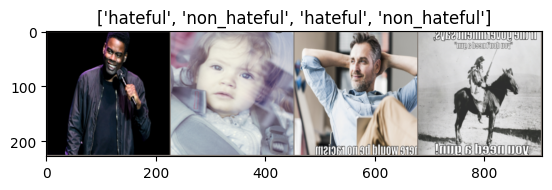

In [47]:
def imshow(inp, mean, std, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, mean, std, title=[class_names[x] for x in classes])

In [48]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            print("I am here")
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [49]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
try:
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=2)
except Exception as e:
    print(e)

Epoch 0/1
----------
I am here


In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['eval']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft)